# Cindy Ho 127008544 Saturation Prediction Algorithm

In [1]:
import splitfolders #this is a python library that divides a folder into testing, training, and validating data
import tensorflow as tf #library for ML
from tensorflow import keras #library to import keras
from keras.preprocessing.image import ImageDataGenerator #keras library for importting images
from keras.models import Sequential #CNN model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D #CNN different layers needed
import numpy as np #for plotting 
import matplotlib.pyplot as plt #for plotting
from sklearn.metrics import classification_report, confusion_matrix #used to view results of CNN model

# Divide into Train/Test/Validate Folders

In [2]:
#library call: call folder where it receives inputs, then call folder where it outputs folder where it's all split up
#seed 1337 means the amount of time it randomizes, seed means it traces how it randomizes & allows it to be reproducible
#ratios - how it divides the data 80% in train, 10% in validate, and last 10% in validation
#group_prefix - allows user to group the folders by filename prefix -> not necessary

splitfolders.ratio(r'C:\Users\cindy\OneDrive\Documents\403\inputimages\TD', output=r'C:\Users\cindy\OneDrive\Documents\403\inputimages\TDoutput2',
    seed=1337, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 7179 files [01:15, 95.57 files/s] 


# Load Image Data 

In [3]:
#ImageDataGenerator implements functions useful for input image scaling and augmentation -- you may want more!
#rescales divides the arrays by 255 (rgb values) to scale it down to 0 and 1
#purpose is to reduce memory when inputting into CNN

train_datagen = ImageDataGenerator(rescale=1./255) #rescales training dataset

valid_datagen = ImageDataGenerator(rescale=1./255) #rescales validation dataset

test_datagen = ImageDataGenerator(rescale=1./255) #rescales testing dataset


In [4]:
train_generator = train_datagen.flow_from_directory(
        r'C:\Users\cindy\OneDrive\Documents\403\inputimages\TDoutput2\train', #image path name
        target_size=(32, 32), #rescales images from 640 x 480 pixels to 32 x 32 to conserve memory
        color_mode='rgb', #image is RGB (red, green blue scale)
        batch_size=1, #only 1 batch is inputted to train model
        class_mode='categorical', #images are grouped into folders from 0-20 in categories therefore its categorical classes
        shuffle=True, #turns on shuffle and shuffles the images
        seed=1953) #amount of time it randomizes, seed means it traces how it randomizes & allows it to be reproducible


valid_generator = valid_datagen.flow_from_directory(
        r'C:\Users\cindy\OneDrive\Documents\403\inputimages\TDoutput2\val',
        target_size=(32, 32), #rescales images from 640 x 480 pixels to 32 x 32 to conserve memory
        color_mode='rgb', #image is RGB (red, green blue scale)
        batch_size=1, #only 1 batch is inputted to train model
        class_mode='categorical', #images are grouped into folders from 0-20 in categories therefore its categorical classes
        shuffle=False, #turns on shuffle and shuffles the images
        seed=1953) #amount of time it randomizes, seed means it traces how it randomizes & allows it to be reproducible


test_generator = test_datagen.flow_from_directory(
    r'C:\Users\cindy\OneDrive\Documents\403\inputimages\TDoutput2\test',
    target_size=(32, 32),  #rescales images from 640 x 480 pixels to 32 x 32 to conserve memory
    color_mode='rgb', #image is RGB (red, green blue scale)
    batch_size=1, #only 1 batch is inputted to train model
    class_mode='categorical', #images are grouped into folders from 0-20 in categories therefore its categorical classes
    shuffle=False, #turns on shuffle and shuffles the images
    seed=1953) #amount of time it randomizes, seed means it traces how it randomizes & allows it to be reproducible


Found 5728 images belonging to 11 classes.
Found 713 images belonging to 11 classes.
Found 727 images belonging to 11 classes.


# Build Neural Network Model

In [9]:
#building the CNN model
model = Sequential()

# input layer (1) 
#filters -> number of filters model will learn = 16 
# kernel size = 2-tuple specifying the width and height of the 2D convolution window (3x3)
# padding = same to preserve the spatial dimensions of the volume for output volume size to match the input volume size
# activiation function used relu -> best loss functions
# input shape = number of images, pixel x pixel value, number of layers
model.add(Conv2D(filters = 16, kernel_size = (3,3), padding='same', activation='relu', input_shape=(32, 32, 3))) 

# max pooling filter to reduce the dimensions of the feature maps by 2x2 (2)
model.add(MaxPooling2D((2,2)))

# conv2D layer (4)
model.add(Conv2D(filters = 16, kernel_size = (3,3), padding='same', activation='relu', input_shape=(32, 32, 3))) 

#max pooling filter to reduce the dimensions of the feature maps by 2x2 (5)
model.add(MaxPooling2D((2,2)))

# flatten layer - to Flattening a tensor means to remove all of the dimensions except for one (7)
model.add(Flatten())  

# dense layer feeds all outputs from the previous layer to all its neurons,
# each neuron providing one output to the next layer (8)
model.add(Dense(16, activation='relu'))

# dense layer repeats previous dense layer but outputs it to 32 instead (9)
model.add(Dense(32, activation='relu'))

# output layer (10)
#11 = number of classes it can be sorted to, linear regression model so use linear
model.add(Dense(11, activation='softmax')) 

In [10]:
# compiles the model utilizing Adam learning rate of 1e-4 & loss function as mean squared log error
# attempted using mean square error, mean abs error, & sparse categorical but best was msle
# accuracy was not used since image regression model focuses only on loss functions
# model.compile(optimizer=keras.optimizers.Adam(lr=1e-4), loss='msle')  
model.compile(optimizer=keras.optimizers.Adam(lr=1e-4), loss='categorical_crossentropy')  

#provides summary of layers within the cnn model, # of parameters inputted, & output shape
model.summary() 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 16)        2320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 16)               

In [11]:
# this is to train the neural network model
# determines steps per epoch for training = the number of batches to be selected for one epoch 
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size 

# determines steps per epoch for validating = the number of batches to be selected for one epoch 
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

model.fit_generator(generator=train_generator, #takes train generator function from above & has model fit it to training data
                    steps_per_epoch=STEP_SIZE_TRAIN, #pulls steps per epoch value above for training
                    validation_data=valid_generator, #takes validate generator function from above & has model test val data
                    validation_steps=STEP_SIZE_VALID, #pulls steps per epoch value above for validating
                    epochs=20 # epochs may be increased but best loss was at 20 epochs
         ) 
#train different epochs & show side by side

Epoch 1/20


C:\Users\cindy\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


5728/5728 [==============================] - 66s 11ms/step - loss: 2.3742 - val_loss: 2.3373
Epoch 2/20
5728/5728 [==============================] - 59s 10ms/step - loss: 2.3005 - val_loss: 2.2626
Epoch 3/20
5728/5728 [==============================] - 61s 11ms/step - loss: 2.2112 - val_loss: 2.1596
Epoch 4/20
5728/5728 [==============================] - 60s 10ms/step - loss: 2.0994 - val_loss: 2.0633
Epoch 5/20
5728/5728 [==============================] - 60s 10ms/step - loss: 1.9876 - val_loss: 1.9512
Epoch 6/20
5728/5728 [==============================] - 62s 11ms/step - loss: 1.8683 - val_loss: 1.8519
Epoch 7/20
5728/5728 [==============================] - 59s 10ms/step - loss: 1.7605 - val_loss: 1.7612
Epoch 8/20
5728/5728 [==============================] - 62s 11ms/step - loss: 1.6517 - val_loss: 1.6325
Epoch 9/20
5728/5728 [==============================] - 60s 11ms/step - loss: 1.5439 - val_loss: 1.5561
Epoch 10/20
5728/5728 [==============================] - 65s 11ms/step - lo

In [8]:
#this is the model predicting with the test image sets
#model predicts with validate data & input number of steps needed per epoch
Y_pred = model.predict(valid_generator, steps=STEP_SIZE_VALID)

#Returns the indices of the maximum values along an axis to determine number of rows to correspond with number of classes
y_pred = np.argmax(Y_pred, axis=1)

#generates the confusion matrix to view results of cnn
#inputs= Ground truth (correct) target values & y pred = estimated targets as returned by a classifier.
print('Confusion Matrix')
print(confusion_matrix(valid_generator.classes, y_pred))

#generates classification report of precision, recall, f1 score, & support
print('Classification Report')
#inputs= Ground truth (correct) target values, y pred = estimated targets as returned by a classifier, & class labels
print(classification_report(valid_generator.classes, y_pred, target_names=valid_generator.class_indices))

Confusion Matrix
[[28 16  0  0  7  0  0  1  2  0  5]
 [ 1 50  1  0  4  1  2  2  6  1  0]
 [ 0  0 42  0  0  1  2  1  0  2  6]
 [ 0  2  0 51  2  6  3  2  3  0  1]
 [ 1  1  1  0 39  1  6  5  1  1  4]
 [ 0  2  2  0  1 58  4  1  2  0  3]
 [ 0  1  1  0  2  3 44  7  0  1  2]
 [ 0  0  3  4  2  4  4 33  2  7  2]
 [ 0  1  6  0  0  4  2  3 37  3  6]
 [ 0  2  3  2  0  2  1  7  1 40  4]
 [ 0  0  4  0  2  3  1  2  1  1 69]]
Classification Report
              precision    recall  f1-score   support

           0       0.93      0.47      0.63        59
           1       0.67      0.74      0.70        68
          10       0.67      0.78      0.72        54
           2       0.89      0.73      0.80        70
           3       0.66      0.65      0.66        60
           4       0.70      0.79      0.74        73
           5       0.64      0.72      0.68        61
           6       0.52      0.54      0.53        61
           7       0.67      0.60      0.63        62
           8       0.71

In [9]:
#this is the model predicting with the test image sets
# determines steps per epoch for testing = the number of batches to be selected for one epoch 
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

#model predicts with test data & input number of steps needed per epoch
Y_pred = model.predict(test_generator, steps=STEP_SIZE_TEST)

#Returns the indices of the maximum values along an axis to determine number of rows to correspond with number of classes
y_pred = np.argmax(Y_pred, axis=1)

#generates the confusion matrix to view results of cnn
#inputs= Ground truth (correct) target values & y pred = estimated targets as returned by a classifier.
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

#generates classification report of precision, recall, f1 score, & support
print('Classification Report')
#inputs= Ground truth (correct) target values, y pred = estimated targets as returned by a classifier, & class labels
print(classification_report(test_generator.classes, y_pred, target_names=train_generator.class_indices))

Confusion Matrix
[[29 18  0  0  3  1  2  1  6  0  0]
 [ 1 50  4  1  6  1  0  1  2  2  1]
 [ 0  0 35  0  0  3  3  4  3  1  6]
 [ 0  0  0 58  0  6  0  3  1  2  1]
 [ 0  0  1  1 42  2  5  6  0  0  4]
 [ 0  0  4  0  1 59  5  4  1  0  1]
 [ 0  0  4  1  2  2 47  5  0  0  2]
 [ 0  0  4  0  2  4  2 37  4  7  3]
 [ 0  1  3  0  1  2  2  4 41  4  5]
 [ 0  0  7  0  1  2  0  5  2 44  2]
 [ 0  2  1  0  0  2  0  0  1  1 77]]
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.48      0.64        60
           1       0.70      0.72      0.71        69
          10       0.56      0.64      0.59        55
           2       0.95      0.82      0.88        71
           3       0.72      0.69      0.71        61
           4       0.70      0.79      0.74        75
           5       0.71      0.75      0.73        63
           6       0.53      0.59      0.56        63
           7       0.67      0.65      0.66        63
           8       0.72

# Demo Example

In [10]:
demo_datagen = ImageDataGenerator(rescale=1./255) #rescales testing dataset

demo_generator = demo_datagen.flow_from_directory(
    r'C:\Users\cindy\OneDrive\Documents\403\inputimages\newtestimages\set2',
    target_size=(32, 32),  #rescales images from 640 x 480 pixels to 32 x 32 to conserve memory
    color_mode='rgb', #image is RGB (red, green blue scale)
    batch_size=1, #only 1 batch is inputted to train model
    class_mode='categorical', #images are grouped into folders from 0-20 in categories therefore its categorical classes
    shuffle=False, #turns on shuffle and shuffles the images
    seed=1953) #amount of time it randomizes, seed means it traces how it randomizes & allows it to be reproducible

#this is the model predicting with the test image sets
# determines steps per epoch for testing = the number of batches to be selected for one epoch 
STEP_SIZE_DEMO = demo_generator.n//demo_generator.batch_size

#model predicts with test data & input number of steps needed per epoch
Y_pred = model.predict(demo_generator, steps=STEP_SIZE_DEMO)

#Returns the indices of the maximum values along an axis to determine number of rows to correspond with number of classes
y_pred = np.argmax(Y_pred, axis=1)

#generates the confusion matrix to view results of cnn
#inputs= Ground truth (correct) target values & y pred = estimated targets as returned by a classifier.
print('Confusion Matrix')
print(confusion_matrix(demo_generator.classes, y_pred))

#generates classification report of precision, recall, f1 score, & support
print('Classification Report')
#inputs= Ground truth (correct) target values, y pred = estimated targets as returned by a classifier, & class labels
print(classification_report(demo_generator.classes, y_pred, target_names=train_generator.class_indices))

Found 1995 images belonging to 11 classes.
Confusion Matrix
[[ 55   9   6  23  38   1  12   0  14   6   7]
 [ 15   0   0  19   9  87  15   3   8   8  12]
 [ 31   7   2  53   8  17  12   2  15  11  18]
 [ 44  14   2  13  23  47   8   1   4  12   8]
 [  1   3   4  20  10 106  18   8  17   1   4]
 [ 11  19   0  42   4  38   0   0  58   0   4]
 [ 28  18   0  12  28  26  50   2  12   7   1]
 [ 30  32   2  16  10  58  17   1   9   1  16]
 [  5   0  25  28   8  27  12  11  42  24   2]
 [  9   3   1  14  70  30  22   1  22   1  11]
 [ 19  15  11  29  33  38   2  11   9   1  16]]
Classification Report
              precision    recall  f1-score   support

           0       0.22      0.32      0.26       171
           1       0.00      0.00      0.00       176
          10       0.04      0.01      0.02       176
           2       0.05      0.07      0.06       176
           3       0.04      0.05      0.05       192
           4       0.08      0.22      0.12       176
           5       0.

In [11]:
import csv
import os
import os.path
from PIL import Image
#opens my csv of labels and reads it into a list of labels
with open(r"C:\Users\cindy\OneDrive\Documents\403\inputimages\singlelabel.csv", newline='') as csvfile:
    labels = list(csv.reader(csvfile))

size = (32,32) #size that I want my image resized to 
    
imgs = [] #list that will hold my images
path =  r"C:\Users\cindy\OneDrive\Documents\403\inputimages\single" #path of images folder
valid_images = [".png"] #extension of images
for f in os.listdir(path): #iterate through every image in folder
    ext = os.path.splitext(f)[1] #adding to list
    if ext.lower() not in valid_images:
        continue
    imgs.append(np.array(Image.open(os.path.join(path,f)).resize(size,resample=0, box=None))) #opening image & adding path to it then appending it to list

for i in range(len(imgs)): #iterates through my images list and scales it by 255 (RGB)
    imgs[i] = (imgs[i].astype(float) / 255.0) #need to preprocess data, need to scale pixels to be between 0-1
    i=i+1
    

[[0.00169356 0.00590914 0.23452011 0.04973525 0.05594357 0.11450691
  0.01946886 0.03298127 0.02917369 0.05005271 0.4060149 ]]


<Figure size 432x288 with 0 Axes>

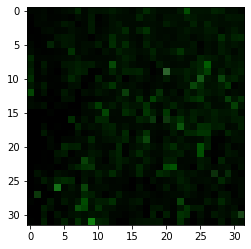

<Figure size 432x288 with 0 Axes>

In [12]:
predictions = model.predict(np.array(imgs)) #prediction on my single image
print(predictions) #print array 
plt.imshow(imgs[0])

plt.figure()